In [1]:
import pandas as pd

pd.set_option('display.width', None)  # 设置最大宽度为None，以适应所有列宽
pd.set_option('display.max_columns', None)  # 显示所有列

train_path = 'data/train/train.csv'
train_bank_path = 'data/train/train_bank_statement.csv'

train_df = pd.read_csv(train_path)
train_bank_df = pd.read_csv(train_bank_path)

test_path = 'data/testaa/testaa.csv'
test_bank_path = 'data/testaa/testaa_bank_statement.csv'

test_df = pd.read_csv(test_path)
test_bank_df = pd.read_csv(test_bank_path)

In [23]:
train, train_bank = train_df.copy(), train_bank_df.copy()
test, test_bank = test_df.copy(), test_bank_df.copy()

In [3]:
train.columns

Index(['id', 'title', 'career', 'zip_code', 'residence', 'loan', 'term',
       'interest_rate', 'issue_time', 'syndicated', 'installment',
       'record_time', 'history_time', 'total_accounts', 'balance_accounts',
       'balance_limit', 'balance', 'level', 'label'],
      dtype='object')

In [4]:
cate_names = ['title', 'career', 'zip_code', 'residence', 'syndicated', 'installment', 'level']
cate_names += ['term']  # term 可以类别、数值都算，后面再比

In [5]:
nume_names = ['loan', 'interest_rate', 'total_accounts', 'balance_accounts', 'balance_limit', 'balance']

# 一、特征工程
## a. 类别特征处理

In [24]:
from sklearn.preprocessing import LabelEncoder

for col in cate_names:
    print(col)
    #train[col] = le.fit_transform(train[col])
    #test[col] = le.transform(test[col])

    #le = LabelEncoder()
    mapping = {cls: idx for idx, cls in enumerate(train_df["title"].unique())}
    
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping).fillna(-1).astype(int)

title
career
zip_code
residence
syndicated
installment
level
term


# b. 新增特征（数值特征为主）

## 1. 流水特征

In [7]:
import pandas as pd
import numpy as np
from functools import reduce


# 补齐日期
def expand_user_days(bank_df):
    bank_df = bank_df.copy()
    bank_df = bank_df.set_index('time').sort_index()
    all_days = pd.date_range(bank_df.index.min(), bank_df.index.max())
    bank_df = bank_df.reindex(all_days, fill_value=0)
    bank_df.index.name = 'time'
    return bank_df


def get_cash_aum(df, bank_df):
    df = df.copy()
    bank_df = bank_df.copy()

    bank_df['time'] = pd.to_datetime(bank_df['time'], unit='s')
    bank_df['amount_signed'] = bank_df['amount'] * bank_df['direction'].map({0: 1, 1: -1})

    # 每日净变动
    daily_change = bank_df.groupby(['id', 'time'])['amount_signed'].sum().reset_index()

    # 注意这里用 group_keys=False，避免多余的索引列
    daily_balance = (
        daily_change.groupby('id', group_keys=False)
        .apply(expand_user_days)
        .reset_index()
    )

    # 计算每日余额（逐日累计）
    daily_balance['balance'] = daily_balance.groupby('id')['amount_signed'].cumsum()

    # 计算月日均 AUM
    daily_balance['year_month'] = daily_balance['time'].dt.to_period('M')

    # 计算月日均 AUM
    monthly_aum = (
        daily_balance.groupby(['id', 'year_month'])['balance']
        .mean()
        .reset_index(name='aum_monthly_avg_daily')
    )

    # 每个用户的最后交易月
    last_month = monthly_aum.groupby('id')['year_month'].max().reset_index(name='last_month')

    # 拼接，计算相对月差
    merged = monthly_aum.merge(last_month, on='id')
    merged['month_diff'] = (merged['last_month'] - merged['year_month']).apply(lambda x: x.n)

    # 提取最近 N 个月
    months = [1, 2, 3, 4, 6]

    features = []
    for m in months:
        tmp = merged[merged['month_diff'] == m - 1][['id', 'aum_monthly_avg_daily']]
        tmp = tmp.rename(columns={'aum_monthly_avg_daily': f'cash_aum_month_avg_last_{m}m'})
        features.append(tmp)

    # 合并特征
    features_df = reduce(lambda l, r: pd.merge(l, r, on='id', how='left'), features)

    #
    df = df.merge(features_df, on='id', how='left')

    return df

def get_span_months(df, bank_df):
    # 交易流水跨度月数
    bank_df["time"] = pd.to_datetime(bank_df["time"], unit='s')
    span_df = bank_df.groupby("id")["time"].agg(["min", "max"]).reset_index()

    # --计算跨度的自然月数
    span_df["cash_span_months"] = (
            (span_df["max"].dt.year - span_df["min"].dt.year) * 12
            + (span_df["max"].dt.month - span_df["min"].dt.month)
            + 1  # 如果要算“覆盖的自然月数” → 加 1
    )

    span_df = span_df.drop(columns=['min', 'max'])

    df = df.merge(span_df, on='id', how='left')
    return df


def get_month_cash_stat(df, bank_df):
    df, bank_df = df.copy(), bank_df.copy()

    bank_df['month'] = pd.to_datetime(bank_df['time'], unit='s').dt.to_period('M').astype(str)

    prefix = 'month'
    # 总转入
    in_df = bank_df[bank_df['direction'] == 0].groupby(['id', 'month'])['amount'].agg(['sum', 'count', 'max']).rename(
        columns={
            'sum': f'{prefix}_in_amount',
            'count': f'{prefix}_in_count',
            'max': f'{prefix}_in_max'
        }
    ).reset_index()

    # 总转出
    out_df = bank_df[bank_df['direction'] == 1].groupby(['id', 'month'])['amount'].agg(['sum', 'count', 'max']).rename(
        columns={'sum': f'{prefix}_out_amount',
                 'count': f'{prefix}_out_count',
                 'max': f'{prefix}_out_max',
                 }
    ).reset_index()

    month_df = in_df.merge(out_df, on=['id', 'month'], how='right')

    # NOTE：净转入应该是 转入 - 转出，修复， 08-29 14:00
    month_df['month_net_amount'] = month_df['month_in_amount'] - month_df['month_out_amount']

    # amount -> count ?
    #month_df['month_neg_net_count'] = (month_df['month_net_amount'] < 0).astype(int)
    month_df['month_neg_net_amount'] = (month_df['month_net_amount'] < 0).astype(int)

    prefix = 'cash_month'
    month_agg_df = month_df.groupby(['id'])['month_neg_net_amount'].agg(['count', 'sum']).rename(
        columns={'count': f'{prefix}_has_trans_months',
                 'sum': f'{prefix}_neg_amount_months'}
    ).reset_index()

    #df = df.merge(month_agg_df, on='id', how='left')

    # ---- 最近 N 个月的净转入/转入/转出 ----
    month_df['month'] = pd.to_datetime(month_df['month'])
    month_df = month_df.sort_values(['id', 'month'])

    for n in [1, 2, 3, 4, 6]:
        # 转入
        month_df[f'cash_month_in_amount_last{n}m'] = (
            month_df.groupby('id')['month_in_amount']
            .transform(lambda x: x.rolling(window=n, min_periods=1).sum())
        )
        # 转出
        month_df[f'cash_month_out_amount_last{n}m'] = (
            month_df.groupby('id')['month_out_amount']
            .transform(lambda x: x.rolling(window=n, min_periods=1).sum())
        )
        # 净转入
        month_df[f'cash_month_net_amount_last{n}m'] = (
            month_df.groupby('id')['month_net_amount']
            .transform(lambda x: x.rolling(window=n, min_periods=1).sum())
        )

    # 取每个用户最后一个月的快照
    last_month_df = (
        month_df.groupby('id')
        .tail(1)
        .drop(columns=['month_neg_net_amount'])  # 这个是中间特征，可以不用留
    )

    # 合并
    final_df = df.merge(month_agg_df, on='id', how='left')
    final_df = final_df.merge(last_month_df, on='id', how='left')

    return final_df

def get_total_cash_stat(df, bank_df):
    # 用户总转入、转出、净转入
    prefix = 'cash_total'

    total_in_df = bank_df[bank_df['direction'] == 0].groupby(['id'])['amount'].agg(['sum', 'count', 'max']).rename(
        columns={
            'sum': f'{prefix}_in_amount',
            'count': f'{prefix}_in_count',
            'max': f'{prefix}_in_max'
        }
    ).reset_index()

    total_out_df = bank_df[bank_df['direction'] == 1].groupby(['id'])['amount'].agg(['sum', 'count', 'max']).rename(
        columns={
            'sum': f'{prefix}_out_amount',
            'count': f'{prefix}_out_count',
            'max': f'{prefix}_out_max'
        }
    ).reset_index()

    df = df.merge(total_in_df, on='id', how='left').merge(total_out_df, on='id', how='left')

    df['cash_total_net_amount'] = df['cash_total_in_amount'] - df['cash_total_out_amount']

    return df

def safe_div(df, a, b, c):
    df[c] = (
    df[a]                           # 分子列
    .div(df[b])                     # 除以分母列（自动处理对齐）
    .replace([np.inf, -np.inf], 0)    # 将除零导致的 inf 替换为 0
    .fillna(0)                        # 将 NaN（分子或分母为 NaN）替换为 0
    )
    return df

def generate_cashflow_features(df, bank_df):
    df = df.copy()
    bank_df = bank_df.copy()

    # 是否有交易流水
    df['cash_has_trans'] = df['id'].isin(bank_df['id']).astype(int)

    # 交易流水跨度月数
    df = get_span_months(df, bank_df)

    # 总转入、转出、净转入
    df = get_total_cash_stat(df, bank_df)

    # 按照月统计，有交易的月数、净转入为负月数
    df = get_month_cash_stat(df, bank_df)

    # 用户交易流水跨度内平均每个月总转入、转出、净转入
    df = safe_div(df, 'cash_total_out_amount', 'cash_span_months', 'cash_avg_out_amount')
    df = safe_div(df, 'cash_total_in_amount', 'cash_span_months', 'cash_avg_in_amount')
    df = safe_div(df, 'cash_total_net_amount', 'cash_span_months', 'cash_avg_net_amount')

    # 增加aum相关
    df = get_cash_aum(df, bank_df)

    return df

In [25]:
# 调用计算得到交易流水特征
#df = train_df.copy()
bank_df = train_bank_df.copy()

train = generate_cashflow_features(train, bank_df)

In [15]:
cash_nume_names = []

for name in train.columns:
    if name.startswith('cash_'):
        cash_nume_names.append(name)

cash_nume_names

['cash_has_trans',
 'cash_span_months',
 'cash_total_in_amount',
 'cash_total_in_count',
 'cash_total_in_max',
 'cash_total_out_amount',
 'cash_total_out_count',
 'cash_total_out_max',
 'cash_total_net_amount',
 'cash_month_has_trans_months',
 'cash_month_neg_amount_months',
 'cash_month_in_amount_last1m',
 'cash_month_out_amount_last1m',
 'cash_month_net_amount_last1m',
 'cash_month_in_amount_last2m',
 'cash_month_out_amount_last2m',
 'cash_month_net_amount_last2m',
 'cash_month_in_amount_last3m',
 'cash_month_out_amount_last3m',
 'cash_month_net_amount_last3m',
 'cash_month_in_amount_last4m',
 'cash_month_out_amount_last4m',
 'cash_month_net_amount_last4m',
 'cash_month_in_amount_last6m',
 'cash_month_out_amount_last6m',
 'cash_month_net_amount_last6m',
 'cash_avg_out_amount',
 'cash_avg_in_amount',
 'cash_avg_net_amount',
 'cash_aum_month_avg_last_1m',
 'cash_aum_month_avg_last_2m',
 'cash_aum_month_avg_last_3m',
 'cash_aum_month_avg_last_4m',
 'cash_aum_month_avg_last_6m']

# 二、模型训练

## 明确所有特征

In [26]:
total_nume_names = nume_names + cash_nume_names

total_cate_names = cate_names

In [27]:
feat_names = total_cate_names + total_nume_names
len(feat_names)

48

In [28]:
X = train[feat_names]
y = train['label']

In [29]:
cate_names

['title',
 'career',
 'zip_code',
 'residence',
 'syndicated',
 'installment',
 'level',
 'term']

In [30]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 20,
    'max_depth': 5,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'min_child_samples': 200,
    'reg_alpha': 3.0,
    'reg_lambda': 4.0,
    'n_estimators': 700
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
auc_scores = []
best_iterations = []
train_auc_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**params)
          
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cate_names,
        eval_metric="val_auc",
        callbacks=[lgb.early_stopping(stopping_rounds=100), 
                   lgb.log_evaluation(100)]
    )

    models.append(model)
    val_pred = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
    oof_preds[val_idx] = val_pred
    
    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)
    best_iterations.append(model.best_iteration_)
    print(f"Fold {fold+1} val_auc: {auc:.6f}")

    y_train_pred = model.predict_proba(X_train, num_iteration=model.best_iteration_)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred)
    train_auc_scores.append(train_auc)

cv_auc = np.mean(auc_scores)
print("\nCV AUC:", cv_auc)
print('\nCV AUC std:', np.std(auc_scores))
print("Fold AUCs:", auc_scores)
print("Best iterations:", best_iterations)
print("\nCV Train AUC:", np.mean(train_auc_scores))
print('CV Train AUC std:', np.std(train_auc_scores))
print('CV Train aucs:', train_auc_scores)

final_auc = roc_auc_score(y, oof_preds)
print("\nOOF AUC:", final_auc)


===== Fold 1 =====
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.648218
[200]	valid_0's auc: 0.650101
[300]	valid_0's auc: 0.650361
Early stopping, best iteration is:
[217]	valid_0's auc: 0.650978
Fold 1 val_auc: 0.650978

===== Fold 2 =====
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.64857
[200]	valid_0's auc: 0.650369
[300]	valid_0's auc: 0.65054
Early stopping, best iteration is:
[219]	valid_0's auc: 0.650735
Fold 2 val_auc: 0.650735

===== Fold 3 =====
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.63881
Early stopping, best iteration is:
[13]	valid_0's auc: 0.640891
Fold 3 val_auc: 0.640891

===== Fold 4 =====
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.659221
[200]	valid_0's auc: 0.66091
Early stopping, best iteration is:
[197]	valid_0's auc: 0.660924
Fold 4 val_auc: 0.660924

===== Fold 5 =====
Training until validation s

# 三、特征重要度分析

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. 获取特征重要性
def visualize_feature_importance(model, feature_names, model_name='v1', max_features=500, figsize=(6, 6)):
    """
    绘制美观的特征重要性图表
    参数:
    model: 训练好的LightGBM模型
    feature_names: 特征名称列表
    max_features: 最大显示特征数(默认显示前50个)
    figsize: 图像尺寸
    """
    # 获取特征重要性值
    #importance = model.feature_importance(importance_type='split')  # 使用'split'类型（按分裂次数计算）
    #importance = model.feature_importance(importance_type='gain')  # 使用'split'类型（按分裂次数计算）
    importance = model.feature_importances_
    
    # 创建排序后的DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # 当特征过多时只显示最重要的部分
    if len(importance_df) > max_features:
        importance_df = importance_df.tail(max_features)
    
    # 2. 创建美观的可视化
    plt.figure(figsize=figsize)
    
    # 使用Seaborn创建水平条形图
    ax = sns.barplot(
        x='Importance', 
        y='Feature', 
        data=importance_df,
        palette='viridis_r',  # 使用反向的Viridis配色
        saturation=0.8
    )
    
    # 3. 添加美观的样式和标签
    plt.title(f'{model_name} Feature Importance', fontsize=14, pad=20)
    plt.xlabel('Importance Score (Gain)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # 添加网格线（浅灰色，半透明）
    ax.grid(True, linestyle='--', alpha=0.6, color='#DDDDDD')
    
    # 添加数值标签
    for i, v in enumerate(importance_df['Importance']):
        ax.text(v + 0.02, i, f"{v:.1f}", color='#333333', va='center', fontsize=9)
    
    # 美化边框
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df, importance

# ===== 使用示例 =====
# 假设已有训练好的LightGBM模型 (lgb_model) 和特征名称列表 (feature_names)
# visualize_feature_importance(lgb_model.booster_, feature_names)

In [32]:
models[0]

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, feature_fraction=0.5,
               learning_rate=0.02, max_depth=5, metric='auc',
               min_child_samples=200, n_estimators=700, num_leaves=20,
               objective='binary', reg_alpha=3.0, reg_lambda=4.0, verbosity=-1)

/var/folders/_8/nqwk9jfs5slg49nr2_bm90hr0000gn/T/ipykernel_57466/2160575787.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


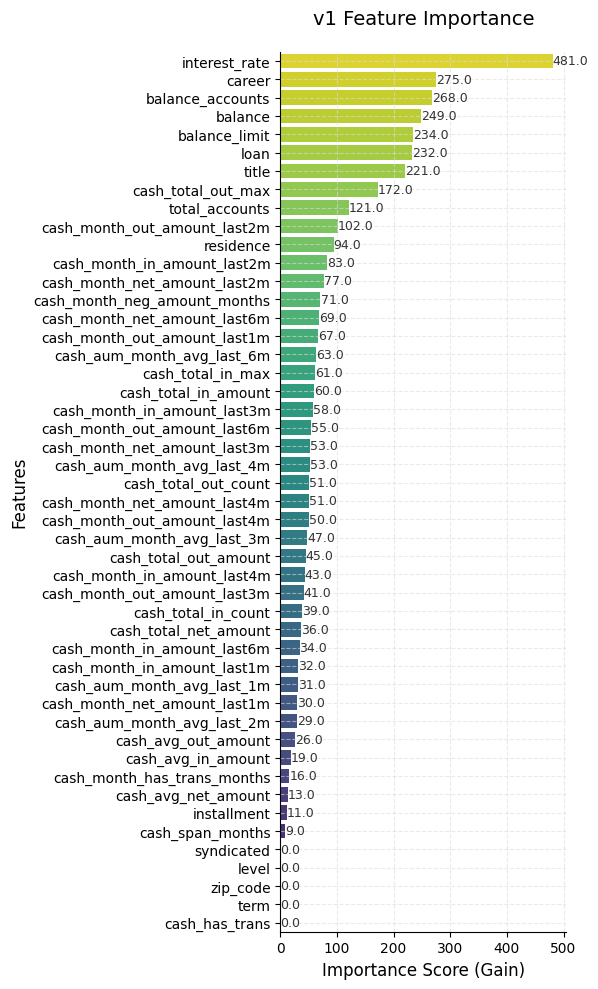

(                         Feature  Importance
 9                  interest_rate         481
 1                         career         275
 11              balance_accounts         268
 13                       balance         249
 12                 balance_limit         234
 8                           loan         232
 0                          title         221
 21            cash_total_out_max         172
 10                total_accounts         121
 29  cash_month_out_amount_last2m         102
 3                      residence          94
 28   cash_month_in_amount_last2m          83
 30  cash_month_net_amount_last2m          77
 24  cash_month_neg_amount_months          71
 39  cash_month_net_amount_last6m          69
 26  cash_month_out_amount_last1m          67
 47    cash_aum_month_avg_last_6m          63
 18             cash_total_in_max          61
 16          cash_total_in_amount          60
 31   cash_month_in_amount_last3m          58
 38  cash_month_out_amount_last6m 

In [34]:
visualize_feature_importance(models[0], feat_names, figsize=(6, 10))

# 四、超参搜索

In [35]:
X = train[feat_names]
y = train['label']
X

,title,career,zip_code,residence,syndicated,installment,level,term,loan,interest_rate,total_accounts,balance_accounts,balance_limit,balance,cash_has_trans,cash_span_months,cash_total_in_amount,cash_total_in_count,cash_total_in_max,cash_total_out_amount,cash_total_out_count,cash_total_out_max,cash_total_net_amount,cash_month_has_trans_months,cash_month_neg_amount_months,cash_month_in_amount_last1m,cash_month_out_amount_last1m,cash_month_net_amount_last1m,cash_month_in_amount_last2m,cash_month_out_amount_last2m,cash_month_net_amount_last2m,cash_month_in_amount_last3m,cash_month_out_amount_last3m,cash_month_net_amount_last3m,cash_month_in_amount_last4m,cash_month_out_amount_last4m,cash_month_net_amount_last4m,cash_month_in_amount_last6m,cash_month_out_amount_last6m,cash_month_net_amount_last6m,cash_avg_out_amount,cash_avg_in_amount,cash_avg_net_amount,cash_aum_month_avg_last_1m,cash_aum_month_avg_last_2m,cash_aum_month_avg_last_3m,cash_aum_month_avg_last_4m,cash_aum_month_avg_last_6m
0,0,7.0,NaN,9,7,9,NaN,NaN,7200,10.95,17.0,9.0,36200.0,13856.00,1,6.0,59707.500000,6.0,10638.10000,12079.500000,42.0,1301.060000,47628.000000,6.0,0.0,10328.400000,763.790000,9564.610000,10328.400000,1954.870000,9564.61000,30329.700000,6087.250000,25433.530000,40298.050000,7029.390000,34459.74000,59707.500000,12079.500000,48819.08000,2013.250000,9951.250000,7938.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000
1,1,4.0,NaN,7,7,7,NaN,NaN,21300,12.95,17.0,9.0,20400.0,13773.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,1,2.0,NaN,9,7,7,NaN,NaN,10400,21.05,17.0,9.0,10800.0,2023.00,1,7.0,6522.380000,4.0,1696.54000,15883.720000,44.0,3394.940000,-9361.340000,7.0,3.0,NaN,3609.080000,NaN,1696.540000,5655.030000,-349.41000,3331.490000,8787.560000,-1846.990000,3331.490000,10702.540000,-1846.99000,5015.840000,13023.330000,-1033.12000,2269.102857,931.768571,-1337.334286,-9273.233333,-5538.170000,-5648.978333,-3118.624286,-1375.686667
3,2,6.0,NaN,7,7,9,NaN,NaN,33050,16.40,17.0,9.0,24700.0,21992.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
4,1,10.0,NaN,9,7,7,NaN,NaN,5200,14.35,17.0,9.0,5100.0,1669.00,1,6.0,20339.900000,6.0,3672.20000,30823.100000,87.0,3561.840000,-10483.200000,6.0,3.0,3344.250000,12591.130000,-9246.880000,6538.000000,14381.290000,-7843.29000,10210.200000,21544.170000,-11333.970000,13370.350000,23091.210000,-9720.86000,20339.900000,30823.100000,-10483.20000,5137.183333,3389.983333,-1747.200000,-6613.362917,-402.454000,1568.347500,550.397778,-294.607273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53475,6,6.0,NaN,9,7,7,NaN,NaN,9000,23.55,12.0,5.0,3535.0,2595.73,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
53476,7,4.0,NaN,9,7,7,NaN,NaN,8000,30.70,5.0,2.0,1965.0,1433.34,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
53477,6,4.0,NaN,9,7,7,NaN,NaN,10000,9.40,12.0,5.0,7253.0,3813.79,1,7.0,44160.408112,112.0,1409.02403,69300.836223,139.0,2215.151184,-25140.428112,7.0,6.0,4566.674466,6235.746855,-1669.072389,14253.790478,19131.482308,-4877.69183,23688.804651,33813.686172,-10124.881521,31954.603178,45277.872759,-13323.26958,44160.408112,69291.373841,-25130.96573,9900.119460,6308.629730,-3591.489730,-24030.025452,-21880.937345,-17163.032750,-14052.944817,-1880.823969
53478,7,4.0,NaN,6,7,7,NaN,NaN,9000,24.40,3.0,3.0,2045.0,1006.40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN


In [37]:
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            categorical_feature=cate_names,
            eval_metric="val_auc",
            callbacks=[lgb.early_stopping(stopping_rounds=100), 
                       lgb.log_evaluation(100)]
        )

        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# -----------------------------
# 创建 study 并优化
# -----------------------------
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # n_trials可根据需求调整

print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print(trial.params)
print('\n')

[I 2025-08-30 14:26:49,096] A new study created in memory with name: no-name-213c32b8-f495-4be7-8d7e-86286422e277


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.645503
Early stopping, best iteration is:
[82]	valid_0's auc: 0.647693
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.652917
[200]	valid_0's auc: 0.645092
Early stopping, best iteration is:
[108]	valid_0's auc: 0.653961
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.636048
Early stopping, best iteration is:
[25]	valid_0's auc: 0.640548
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.651956
Early stopping, best iteration is:
[47]	valid_0's auc: 0.658869
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.649445


[I 2025-08-30 14:27:00,501] Trial 0 finished with value: 0.6515762681761479 and parameters: {'learning_rate': 0.06517297560370597, 'num_leaves': 69, 'max_depth': 12, 'feature_fraction': 0.9747476215415374, 'bagging_fraction': 0.5038486661815997, 'bagging_freq': 1, 'min_child_samples': 181, 'reg_alpha': 1.2020859097468783, 'reg_lambda': 2.7742992104857764, 'n_estimators': 2963}. Best is trial 0 with value: 0.6515762681761479.


Early stopping, best iteration is:
[20]	valid_0's auc: 0.65681
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.646491
Early stopping, best iteration is:
[35]	valid_0's auc: 0.65171
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.64753
Early stopping, best iteration is:
[48]	valid_0's auc: 0.652296
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.639637


[W 2025-08-30 14:27:05,122] Trial 1 failed with parameters: {'learning_rate': 0.09855011703879897, 'num_leaves': 126, 'max_depth': 10, 'feature_fraction': 0.6527547203430346, 'bagging_fraction': 0.916511691349664, 'bagging_freq': 4, 'min_child_samples': 456, 'reg_alpha': 5.635804884897507, 'reg_lambda': 4.527348606950394, 'n_estimators': 2156} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/feynmanma/anaconda3/envs/python38/lib/python3.8/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/_8/nqwk9jfs5slg49nr2_bm90hr0000gn/T/ipykernel_57466/1689524802.py", line 30, in objective
    model.fit(
  File "/Users/feynmanma/anaconda3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py", line 1268, in fit
    super().fit(
  File "/Users/feynmanma/anaconda3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py", line 954, in fit
    self._Booster = train(


KeyboardInterrupt: 

# 五、最优参数重新训练

In [ ]:
X = train[feat_names]
y = train['label']

In [38]:
params = {'learning_rate': 0.021295297369576544, 'num_leaves': 63, 'max_depth': 4, 'feature_fraction': 0.586486381626894, 'bagging_fraction': 0.8514263771699546, 'bagging_freq': 8, 'min_child_samples': 175, 'reg_alpha': 7.267366553673977, 'reg_lambda': 5.194323729803619, 'n_estimators': 2519}
params

{'learning_rate': 0.021295297369576544,
 'num_leaves': 63,
 'max_depth': 4,
 'feature_fraction': 0.586486381626894,
 'bagging_fraction': 0.8514263771699546,
 'bagging_freq': 8,
 'min_child_samples': 175,
 'reg_alpha': 7.267366553673977,
 'reg_lambda': 5.194323729803619,
 'n_estimators': 2519}

In [39]:
# 使用寻参得到的最优参数 ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
auc_scores = []
best_iterations = []
train_auc_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**params)
          
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cate_names,
        eval_metric="val_auc",
        callbacks=[lgb.early_stopping(stopping_rounds=100), 
                   lgb.log_evaluation(100)]
    )

    models.append(model)
    val_pred = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
    oof_preds[val_idx] = val_pred
    
    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)
    best_iterations.append(model.best_iteration_)
    print(f"Fold {fold+1} val_auc: {auc:.6f}")

    y_train_pred = model.predict_proba(X_train, num_iteration=model.best_iteration_)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred)
    train_auc_scores.append(train_auc)

cv_auc = np.mean(auc_scores)
print("\nCV AUC:", cv_auc)
print('\nCV AUC std:', np.std(auc_scores))
print("Fold AUCs:", auc_scores)
print("Best iterations:", best_iterations)
print("\nCV Train AUC:", np.mean(train_auc_scores))
print('CV Train AUC std:', np.std(train_auc_scores))
print('CV Train aucs:', train_auc_scores)

final_auc = roc_auc_score(y, oof_preds)
print("\nOOF AUC:", final_auc)


===== Fold 1 =====
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.586486381626894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.586486381626894
[LightGBM] [Warning] bagging_fraction is set=0.8514263771699546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514263771699546
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.586486381626894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.586486381626894
[LightGBM] [Warning] bagging_fraction is set=0.8514263771699546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514263771699546
[LightGBM] [Info] Number of positive: 7911, number of negative: 34873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 s